In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving opt-target.csv to opt-target.csv
Saving X_iter_imputed.csv to X_iter_imputed.csv


In [3]:
import io
feature = pd.read_csv(io.BytesIO(uploaded['X_iter_imputed.csv'])) 
optimal_target = pd.read_csv(io.BytesIO(uploaded['opt-target.csv'])) 

In [4]:
optimal_target = optimal_target.drop(columns = 'Unnamed: 0')
feature = feature.drop(columns = 'Unnamed: 0')

In [6]:
feature['mean_Q1_2_3_mouth'] = feature['mean_Q1_Speech'] + feature['mean_Q2_Salivation'] + feature['mean_Q3_Swallowing']
feature['mean_Q8_9_leg'] = feature['mean_Q8_Walking'] + feature['mean_Q9_Climbing_Stairs'] 
feature.describe()

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,Creatinine_mean,Creatinine_slope,alsfrs_total_slope,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,weight_slope,mean_Q1_2_3_mouth,mean_Q8_9_leg
count,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.000000,4088.00000
mean,504015.218200,55.518346,0.624755,-285.486301,-621.696673,0.199119,336.210372,-0.095202,80.471598,74.454161,-0.013811,-0.028591,3.102412,3.368328,3.412027,2.902758,2.574496,2.411709,2.960464,2.618161,1.857029,3.550063,-0.002019,-0.001573,-0.002003,-0.002785,-0.003739,-0.004019,-0.003292,-0.002519,-0.004178,-0.001913,-0.018392,9.882767,4.47519
std,293292.344135,11.682202,0.484245,314.142221,402.428866,0.399387,256.610317,0.345283,21.186425,19.239240,0.395487,0.072470,1.035763,0.877938,0.785405,1.038670,1.175604,1.025238,0.954621,0.930951,1.337890,0.622749,0.016779,0.015442,0.014490,0.017067,0.017567,0.016594,0.018006,0.013141,0.022085,0.016931,0.069916,2.463846,2.18349
min,329.000000,18.000000,0.000000,-7372.000000,-8741.000000,0.000000,-199.000000,-3.400000,0.000000,0.000000,-2.009091,-1.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.125000,-0.153846,-0.333333,-0.250000,-0.285714,-0.200000,-0.428571,-0.125000,-0.333333,-0.142857,-1.346154,0.000000,0.00000
25%,252447.250000,47.000000,0.000000,-375.000000,-777.000000,0.000000,168.000000,-0.224492,68.000000,61.871039,-0.121223,-0.053571,2.600000,3.000000,3.000000,2.500000,1.666667,2.000000,2.333333,2.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-0.011038,-0.011494,-0.009125,0.000000,-0.011236,0.000000,-0.047619,8.750000,3.00000
50%,512430.500000,56.000000,1.000000,-195.000000,-535.500000,0.000000,273.000000,-0.073904,81.000000,75.140000,0.000000,-0.020408,3.250000,4.000000,4.000000,3.000000,3.000000,2.500000,3.000000,2.500000,1.500000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012821,10.750000,4.00000
75%,763929.000000,64.000000,1.000000,-90.000000,-359.000000,0.000000,426.000000,0.034555,94.250000,88.400000,0.075290,0.000000,4.000000,4.000000,4.000000,4.000000,3.500000,3.000000,4.000000,3.250000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011643,12.000000,6.00000
max,999990.000000,84.000000,1.000000,0.000000,-24.000000,1.000000,2708.000000,8.333333,161.544472,344.760000,17.109677,1.666667,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,0.666667,0.230769,0.153846,0.333333,0.153846,0.285714,0.181818,0.333333,0.500000,0.333333,1.492683,12.000000,8.00000


In [7]:
feature = feature[['SubjectID', 'Age', 'onset_delta', 'fvc_mean', 'Creatinine_mean', 'alsfrs_total_slope',  'mean_Q1_2_3_mouth',
       'mean_Q5_Cutting', 'mean_Q8_9_leg', 'slope_Q1_Speech', 'slope_Q2_Salivation',
       'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q5_Cutting', 'slope_Q9_Climbing_Stairs', 'weight_slope']]

In [120]:
X_full = pd.merge(feature, optimal_target, on = 'SubjectID')

In [121]:
X_full = X_full[X_full['time_opt']!=0]

In [76]:
df_train = X_full.drop(columns='SubjectID')

In [12]:
!pip install lifelines

     |████████████████████████████████| 348 kB 9.1 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=f794c09c2aa319fa7f6b451f43ddfc4e162711216ea5fa9c40531b2e4f830859
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


##Cox Proportional Hazard model

In [77]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_train, 'time_opt', event_col='status_opt')

<lifelines.CoxPHFitter: fitted with 3324 total observations, 2198 right-censored observations>

In [78]:
cph_median = pd.concat([X_full['SubjectID'],cph.predict_median(df_train)], axis=1)
cph_median

,SubjectID,0.5
0,329.0,inf
1,348.0,884.0
2,708.0,353.0
3,902.0,515.0
5,1736.0,186.0
...,...,...
3443,998756.0,291.0
3444,999166.0,515.0
3445,999823.0,313.0
3446,999880.0,inf


In [79]:
print('There are ' + str(cph_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in cph_median')

There are 142 inf values in cph_median


In [80]:
cph_median_max = cph_median.replace([np.inf,-np.inf], np.nan).dropna(subset=[0.5],how='all')[0.5].max()
cph_inf = cph_median_max + 200
cph_median = cph_median.replace([np.inf,-np.inf], cph_inf)

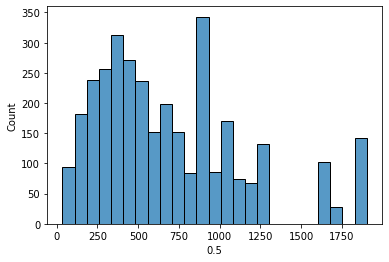

In [81]:
sns.histplot(x = cph_median[0.5])

In [82]:
cph_median.describe()

,SubjectID,0.5
count,3324.000000,3324.000000
mean,508053.875752,695.268051
std,293158.568078,454.855262
min,329.000000,35.000000
25%,255278.000000,353.000000
50%,517427.500000,588.000000
75%,767715.750000,929.000000
max,999990.000000,1902.000000


In [83]:
cph_slow_list = list(cph_median[cph_median[0.5] >= 929]['SubjectID'])
cph_medium_list = list(cph_median[(cph_median[0.5] >= 353) & (cph_median[0.5] < 929)]['SubjectID'])
cph_fast_list = list(cph_median[cph_median[0.5]  < 353]['SubjectID'])
X_cph_slow = X_full[X_full['SubjectID'].isin(cph_slow_list)]
X_cph_medium = X_full[X_full['SubjectID'].isin(cph_medium_list)]
X_cph_fast = X_full[X_full['SubjectID'].isin(cph_fast_list)]

In [84]:
VIRT_cph_slow = pd.DataFrame(X_cph_slow.mean()).transpose().iloc[:, 1:-2]
VIRT_cph_medium = pd.DataFrame(X_cph_medium.mean()).transpose().iloc[:, 1:-2]
VIRT_cph_fast = pd.DataFrame(X_cph_fast.mean()).transpose().iloc[:, 1:-2]

In [85]:
result_cph_slow = cph.predict_survival_function(VIRT_cph_slow)
result_cph_medium = cph.predict_survival_function(VIRT_cph_medium)
result_cph_fast = cph.predict_survival_function(VIRT_cph_fast)

In [86]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

from lifelines.utils import median_survival_times

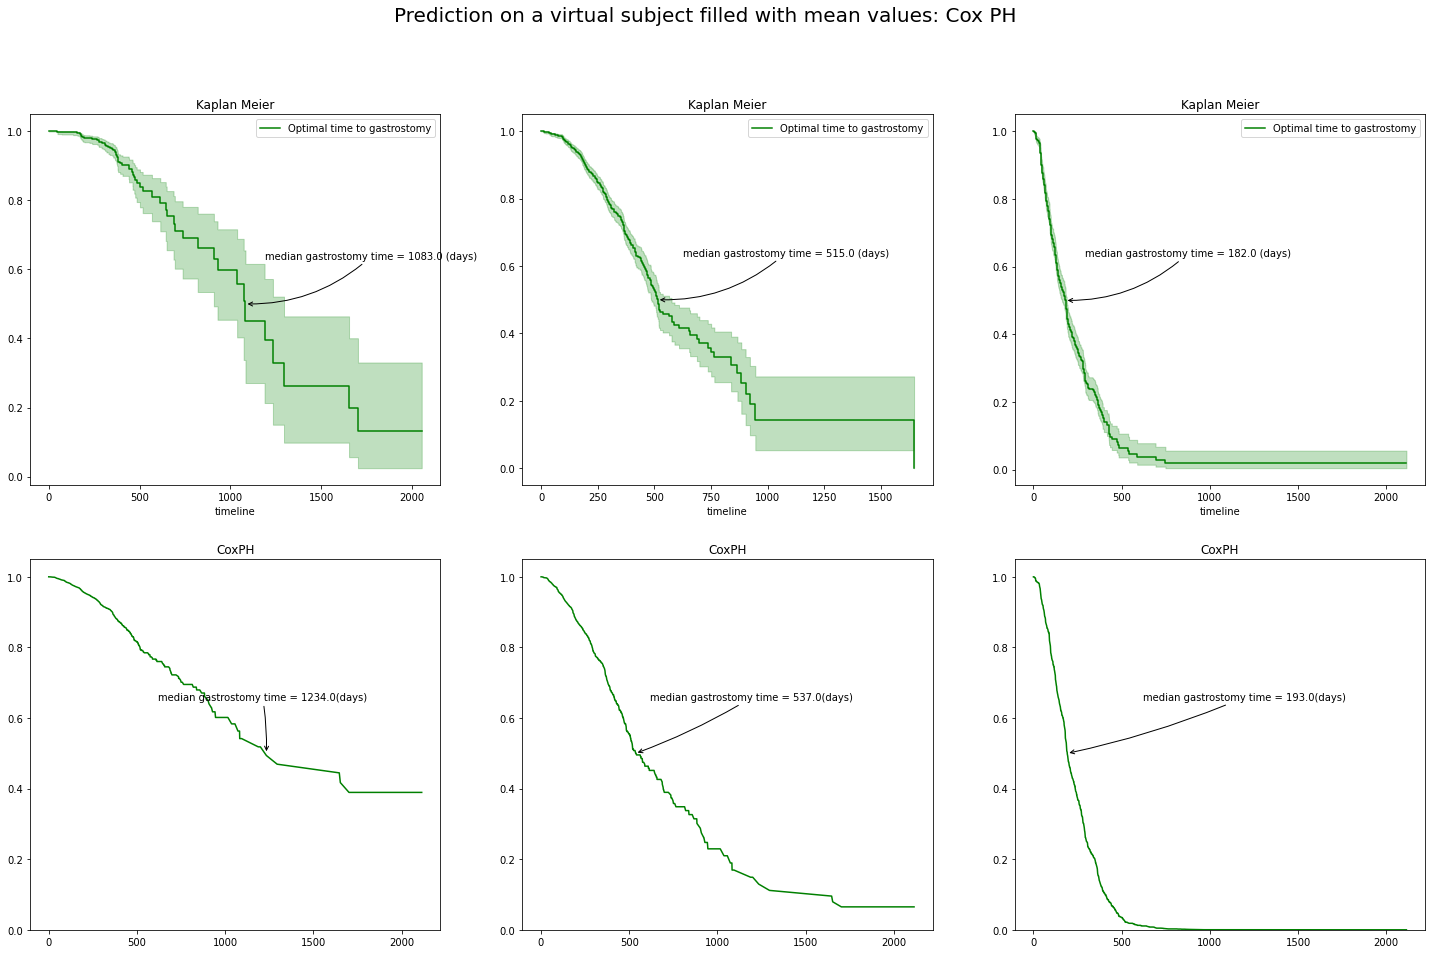

In [87]:
plt.figure(figsize=(25, 15))

plt.subplot(231)
OPT = kmf.fit(X_cph_slow["time_opt"], X_cph_slow["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(232)
OPT = kmf.fit(X_cph_medium["time_opt"], X_cph_medium["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(233)
OPT = kmf.fit(X_cph_fast["time_opt"], X_cph_fast["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(234)
plt.plot(result_cph_slow.index, result_cph_slow, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(cph.predict_median(VIRT_cph_slow)) +"(days)", xy=(cph.predict_median(VIRT_cph_slow), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(235)
plt.plot(result_cph_medium.index, result_cph_medium, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(cph.predict_median(VIRT_cph_medium)) +"(days)", xy=(cph.predict_median(VIRT_cph_medium), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(236)
plt.plot(result_cph_fast.index, result_cph_fast, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(cph.predict_median(VIRT_cph_fast)) +"(days)", xy=(cph.predict_median(VIRT_cph_fast), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.suptitle('Prediction on a virtual subject filled with mean values: Cox PH', fontsize=20)
plt.show()

## Random Survival Forest

In [24]:
!pip install --upgrade pip
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival

     |████████████████████████████████| 1.6 MB 8.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 2.4 MB 8.1 MB/s 
  distutils: /usr/lib/python3/dist-packages
  sysconfig: /usr/lib/python3.7/site-packages
  user = False
  home = None
  root = None
  prefix = None
  distutils: /usr/lib/python3/dist-packages
  sysconfig: /usr/lib/python3.7/site-packages
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
 

In [88]:
from sksurv.ensemble import RandomSurvivalForest

dic = {1:True, 0:False}

df_train_rsf = df_train.iloc[:, -2:][['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})

arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt=np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']

rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=12,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train.iloc[:,:-2], y_train_rsf)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=12,
                     min_samples_split=8, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [89]:
def predict_rsf_median(data):
  result = rsf.predict_survival_function(data.to_numpy().reshape(1, -1), return_array = True)
  result = np.squeeze(result)
  time_result = pd.DataFrame({'time' : rsf.event_times_, 'p' : result })

  if time_result[time_result['p'] <= 0.5].count()['time'] == 0:
    median = np.inf
  else:
    median = time_result[time_result['p'] <= 0.5].iloc[0,0]

  return median

In [90]:
rsf_median_list = []
for i in range(df_train.shape[0]):
  rsf_median_list.append(predict_rsf_median(df_train.iloc[i,:-2]))

rsf_median_list

[1647.0,
 inf,
 99.0,
 518.0,
 180.0,
 inf,
 inf,
 290.0,
 444.0,
 252.0,
 765.0,
 248.0,
 392.0,
 188.0,
 519.0,
 515.0,
 184.0,
 288.0,
 1295.0,
 413.0,
 1647.0,
 318.0,
 inf,
 inf,
 444.0,
 inf,
 1234.0,
 495.0,
 440.0,
 inf,
 472.0,
 inf,
 364.0,
 360.0,
 497.0,
 inf,
 443.0,
 253.0,
 312.0,
 461.0,
 1234.0,
 inf,
 1083.0,
 178.0,
 413.0,
 884.0,
 inf,
 1702.0,
 70.0,
 413.0,
 308.0,
 688.0,
 47.0,
 495.0,
 394.0,
 204.0,
 210.0,
 372.0,
 258.0,
 385.0,
 126.0,
 515.0,
 inf,
 820.0,
 393.0,
 576.0,
 518.0,
 366.0,
 253.0,
 inf,
 461.0,
 inf,
 1073.0,
 inf,
 193.0,
 246.0,
 inf,
 428.0,
 47.0,
 614.0,
 389.0,
 181.0,
 294.0,
 inf,
 280.0,
 1295.0,
 188.0,
 inf,
 1083.0,
 inf,
 363.0,
 1653.0,
 290.0,
 518.0,
 309.0,
 1647.0,
 363.0,
 335.0,
 373.0,
 525.0,
 inf,
 688.0,
 867.0,
 inf,
 inf,
 341.0,
 576.0,
 289.0,
 inf,
 484.0,
 71.0,
 91.0,
 946.0,
 1653.0,
 565.0,
 909.0,
 259.0,
 444.0,
 81.0,
 1702.0,
 389.0,
 520.0,
 inf,
 1234.0,
 909.0,
 341.0,
 441.0,
 91.0,
 inf,
 inf,
 286.

In [122]:
subjectID = X_full['SubjectID'].copy()
subjectID.index = range(len(subjectID))
subjectID

0          329.0
1          348.0
2          708.0
3          902.0
4         1736.0
          ...   
3319    998756.0
3320    999166.0
3321    999823.0
3322    999880.0
3323    999990.0
Name: SubjectID, Length: 3324, dtype: float64

In [123]:
rsf_median = pd.concat([subjectID, pd.Series(rsf_median_list)], axis=1)
rsf_median

,SubjectID,0
0,329.0,1647.0
1,348.0,inf
2,708.0,99.0
3,902.0,518.0
4,1736.0,180.0
...,...,...
3319,998756.0,252.0
3320,999166.0,483.0
3321,999823.0,93.0
3322,999880.0,inf


In [124]:
print('There are ' + str(rsf_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in rsf_median')

There are 767 inf values in rsf_median


In [125]:
rsf_median_max = rsf_median.replace([np.inf,-np.inf], np.nan).dropna(subset=[0],how='all')[0].max()
rsf_inf = rsf_median_max + 200
rsf_median = rsf_median.replace([np.inf,-np.inf], rsf_inf)

In [126]:
rsf_median_max

1702.0

In [127]:
rsf_median[rsf_median[0]==1702]

,SubjectID,0
47,13212.0,1702.0
119,32933.0,1702.0
145,41382.0,1702.0
185,52635.0,1702.0
273,76650.0,1702.0
...,...,...
2994,913477.0,1702.0
3013,920529.0,1702.0
3258,983209.0,1702.0
3294,992712.0,1702.0


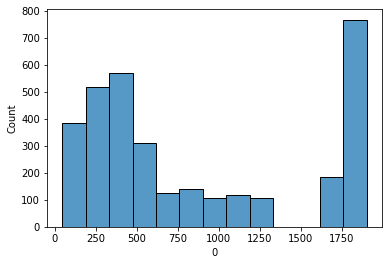

In [128]:
sns.histplot(x = rsf_median[0])

In [129]:
rsf_median.describe()

,SubjectID,0
count,3324.000000,3324.000000
mean,508053.875752,876.886282
std,293158.568078,678.914168
min,329.000000,47.000000
25%,255278.000000,301.000000
50%,517427.500000,520.000000
75%,767715.750000,1702.000000
max,999990.000000,1902.000000


In [130]:
rsf_slow_list = list(rsf_median[rsf_median[0] >= 1702]['SubjectID'])
rsf_medium_list = list(rsf_median[(rsf_median[0] >= 301) & (rsf_median[0] < 1702)]['SubjectID'])
rsf_fast_list = list(rsf_median[rsf_median[0]  < 301]['SubjectID'])
X_rsf_slow = X_full[X_full['SubjectID'].isin(rsf_slow_list)]
X_rsf_medium = X_full[X_full['SubjectID'].isin(rsf_medium_list)]
X_rsf_fast = X_full[X_full['SubjectID'].isin(rsf_fast_list)]

In [131]:
VIRT_rsf_slow = pd.DataFrame(X_rsf_slow.mean()).transpose().iloc[:, 1:-2]
VIRT_rsf_medium = pd.DataFrame(X_rsf_medium.mean()).transpose().iloc[:, 1:-2]
VIRT_rsf_fast = pd.DataFrame(X_rsf_fast.mean()).transpose().iloc[:, 1:-2]

In [132]:
predict_rsf_median(VIRT_rsf_fast)

182.0

In [133]:
result_rsf_slow = rsf.predict_survival_function(VIRT_rsf_slow, return_array=True)
result_rsf_medium = rsf.predict_survival_function(VIRT_rsf_medium, return_array=True)
result_rsf_fast = rsf.predict_survival_function(VIRT_rsf_fast, return_array=True)

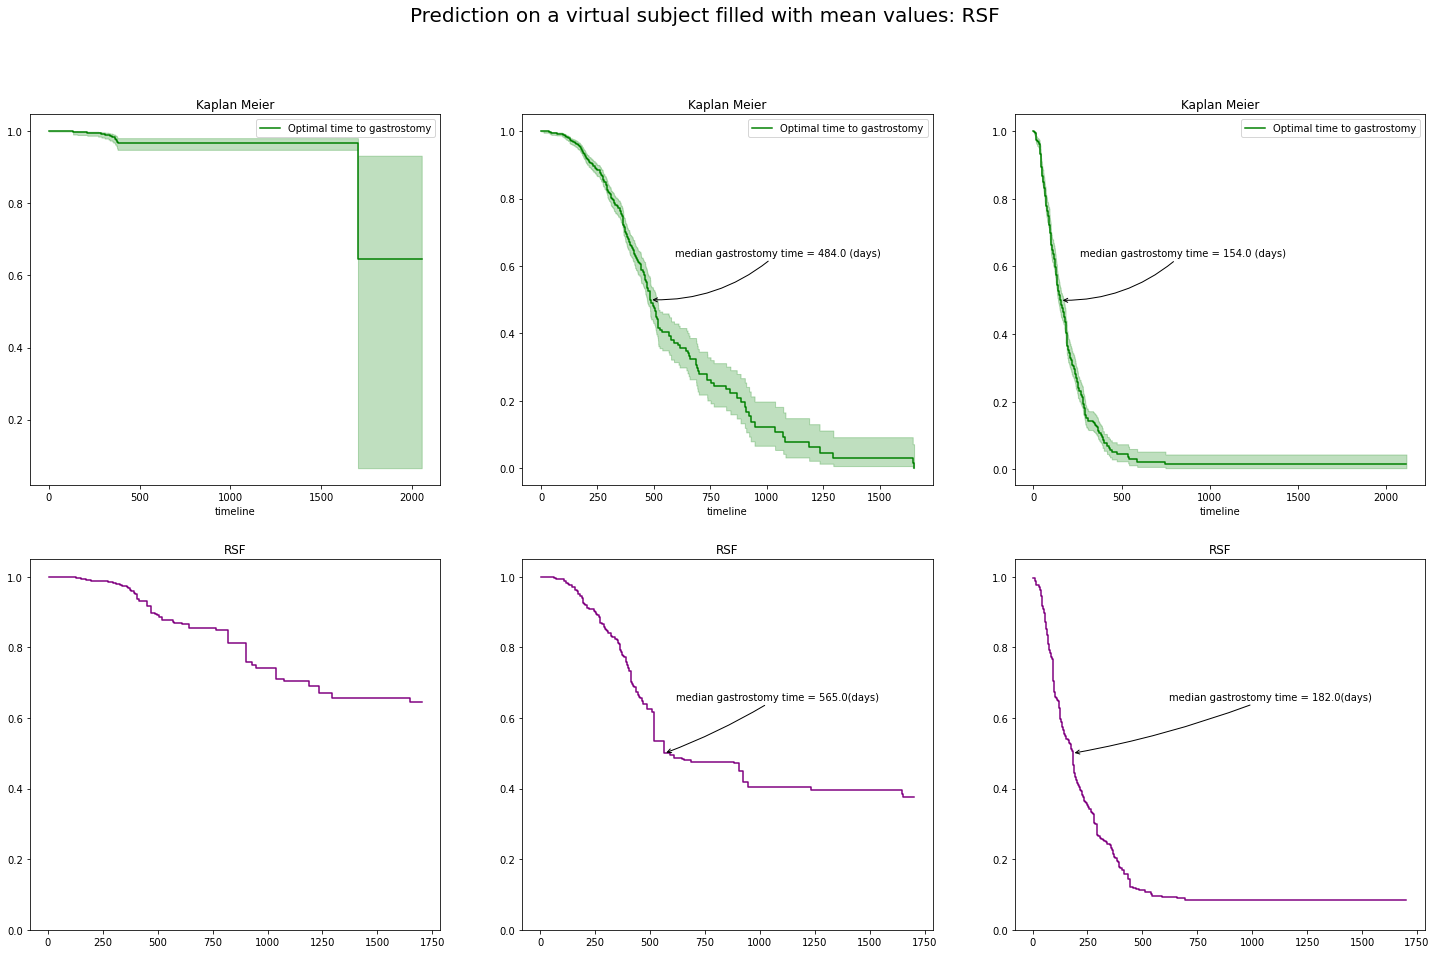

In [134]:
plt.figure(figsize=(25, 15))

plt.subplot(231)
OPT = kmf.fit(X_rsf_slow["time_opt"], X_rsf_slow["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")


plt.subplot(232)
OPT = kmf.fit(X_rsf_medium["time_opt"], X_rsf_medium["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(233)
OPT = kmf.fit(X_rsf_fast["time_opt"], X_rsf_fast["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(234)
for i, s in enumerate(result_rsf_slow):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.title('RSF')

plt.subplot(235)
for i, s in enumerate(result_rsf_medium):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(predict_rsf_median(VIRT_rsf_medium)) +"(days)", xy=(predict_rsf_median(VIRT_rsf_medium), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))
plt.title('RSF')

plt.subplot(236)
for i, s in enumerate(result_rsf_fast):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(predict_rsf_median(VIRT_rsf_fast)) +"(days)", xy=(predict_rsf_median(VIRT_rsf_fast), 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))
plt.title('RSF')

plt.suptitle('Prediction on a virtual subject filled with mean values: RSF', fontsize=20)
plt.show()

## Accelerated Failure Time model

In [135]:
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter()
aft.fit(df_train, 'time_opt', 'status_opt', ancillary=False)

<lifelines.WeibullAFTFitter: fitted with 3324 total observations, 2198 right-censored observations>

In [136]:
aft_median = pd.concat([X_full['SubjectID'],aft.predict_median(df_train)], axis=1)
aft_median

,SubjectID,0
0,329.0,1547.711587
1,348.0,825.268497
2,708.0,358.670885
3,902.0,538.966780
5,1736.0,190.267725
...,...,...
3443,998756.0,289.555503
3444,999166.0,568.320194
3445,999823.0,317.346413
3446,999880.0,2968.796084


In [137]:
print('There are ' + str(aft_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in aft_median')

There are 0 inf values in aft_median


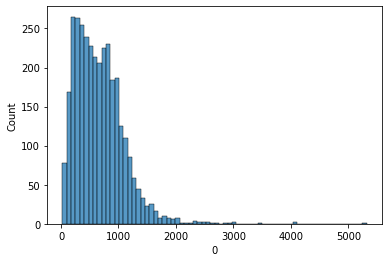

In [138]:
sns.histplot(x = aft_median[0])

In [139]:
aft_median.describe()

,SubjectID,0
count,3324.000000,3324.000000
mean,508053.875752,666.754583
std,293158.568078,422.269907
min,329.000000,24.289744
25%,255278.000000,340.145601
50%,517427.500000,616.596447
75%,767715.750000,905.845601
max,999990.000000,5319.789601


In [140]:
aft_slow_list = list(aft_median[aft_median[0] >= 905.845601]['SubjectID'])
aft_medium_list = list(aft_median[(aft_median[0] >= 340.145601) & (cph_median[0.5] < 905.845601)]['SubjectID'])
aft_fast_list = list(aft_median[aft_median[0]  < 340.145601]['SubjectID'])
X_aft_slow = X_full[X_full['SubjectID'].isin(aft_slow_list)]
X_aft_medium = X_full[X_full['SubjectID'].isin(aft_medium_list)]
X_aft_fast = X_full[X_full['SubjectID'].isin(aft_fast_list)]

In [141]:
VIRT_aft_slow = pd.DataFrame(X_aft_slow.mean()).transpose().iloc[:, 1:-2]
VIRT_aft_medium = pd.DataFrame(X_aft_medium.mean()).transpose().iloc[:, 1:-2]
VIRT_aft_fast = pd.DataFrame(X_aft_fast.mean()).transpose().iloc[:, 1:-2]

In [142]:
result_aft_slow = aft.predict_survival_function(VIRT_aft_slow)
result_aft_medium = aft.predict_survival_function(VIRT_aft_medium)
result_aft_fast = aft.predict_survival_function(VIRT_aft_fast)

In [143]:
aft.predict_median(VIRT_aft_slow)[0]

1178.2135406184943

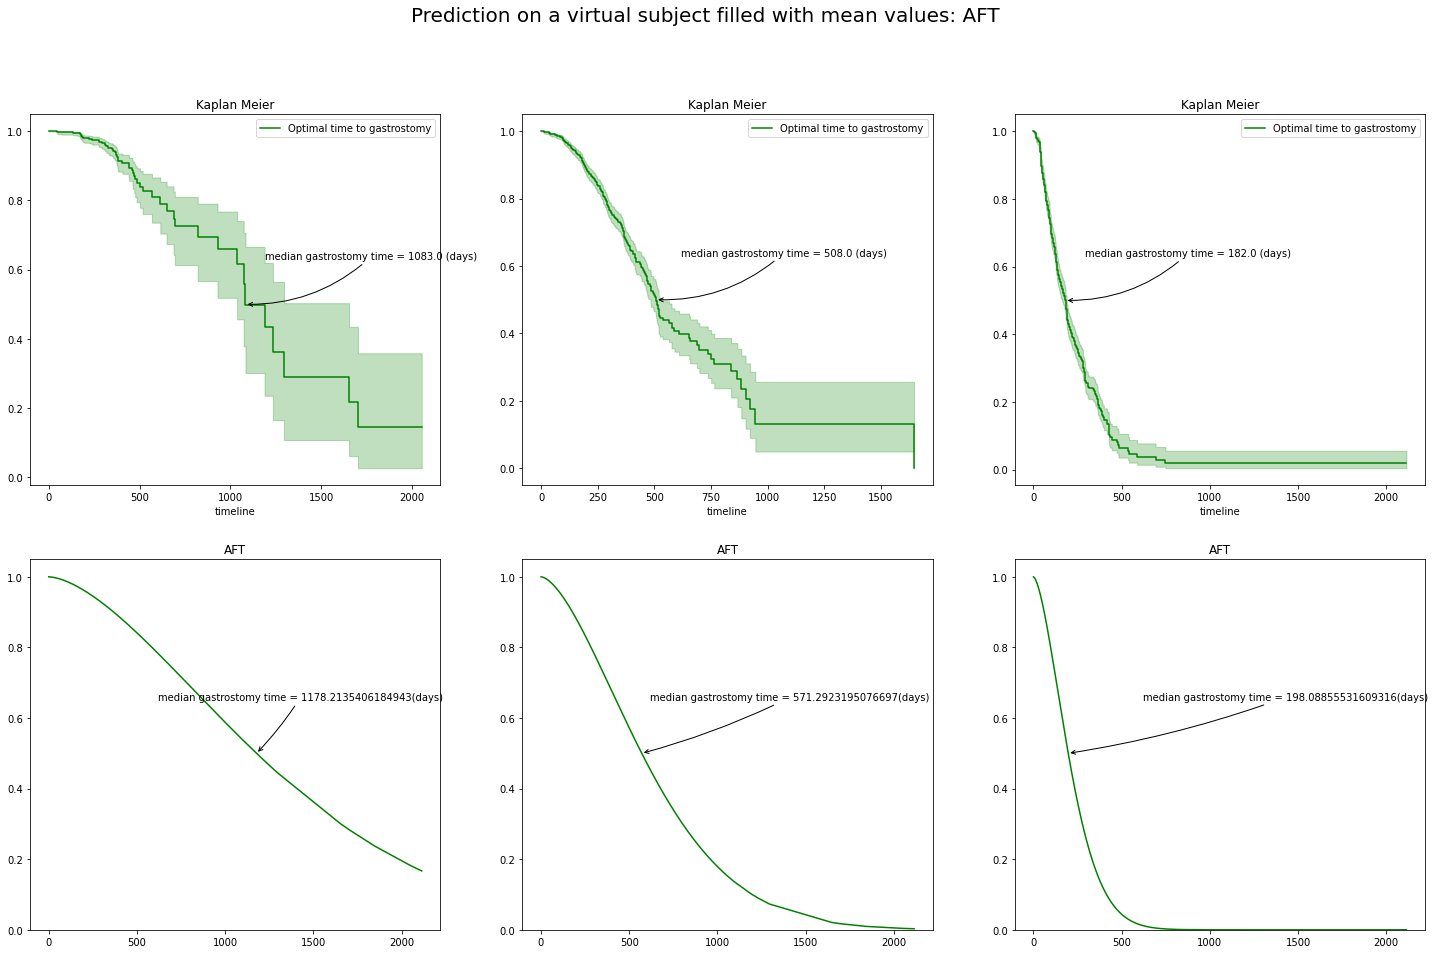

In [144]:
plt.figure(figsize=(25, 15))

plt.subplot(231)
OPT = kmf.fit(X_aft_slow["time_opt"], X_aft_slow["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(232)
OPT = kmf.fit(X_aft_medium["time_opt"], X_aft_medium["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(233)
OPT = kmf.fit(X_aft_fast["time_opt"], X_aft_fast["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.title("Kaplan Meier")
plt.annotate("median gastrostomy time = "+str(OPT.median_survival_time_)+" (days)", xy=(float(OPT.median_survival_time_), 0.5)
                , xytext=(float(OPT.median_survival_time_)+110, 0.63), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

plt.subplot(234)
plt.plot(result_aft_slow.index, result_aft_slow[0], marker='None', color='green')
plt.title("AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(aft.predict_median(VIRT_aft_slow)[0]) +"(days)", xy=(aft.predict_median(VIRT_aft_slow)[0], 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(235)
plt.plot(result_aft_medium.index, result_aft_medium[0], marker='None', color='green')
plt.title("AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(aft.predict_median(VIRT_aft_medium)[0]) +"(days)", xy=(aft.predict_median(VIRT_aft_medium)[0], 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(236)
plt.plot(result_aft_fast.index, result_aft_fast[0], marker='None', color='green')
plt.title("AFT")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = "+ str(aft.predict_median(VIRT_aft_fast)[0]) +"(days)", xy=(aft.predict_median(VIRT_aft_fast)[0], 0.5)
                , xytext=(510+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.suptitle('Prediction on a virtual subject filled with mean values: AFT', fontsize=20)
plt.show()